In [6]:
# Imports
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display

# @title Helper functions (MLP Tutorial 1 Codes)

# @markdown `Net(nn.Module)`

class Net(nn.Module):
  """
  Simulate MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: list
        Number of units per hidden layer. List of integers
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshapinng later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one
      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output
      self.mlp.add_module(f"Linear_{i}", layer) # Append layer to the model with a name

      actv_layer = eval(f"nn.{actv}") # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module(f"Activation_{i}", actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    logits = self.mlp(x) # forward pass of MLP
    return logits


# @markdown `train_test_classification(net, criterion, optimizer, train_loader, test_loader, num_epochs=1, verbose=True, training_plot=False)`
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: Instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """
  net.to(device)
  net.train()
  training_losses = []
  for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Print statistics
      if verbose:
        training_losses += [loss.item()]

  net.eval()

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
        Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f'\nAccuracy on the {train_total} training samples: {train_acc:0.2f}')
    print(f'Accuracy on the {test_total} testing samples: {test_acc:0.2f}\n')

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc


# @markdown `shuffle_and_split_data(X, y, seed)`
def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  # Set seed for reproducibility
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]
  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(0.2 * N)    # Assign test datset size using 20% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train

  # @title Plotting functions
def imshow(img):
  """
  Helper function to plot unnormalised image

  Args:
    img: torch.tensor
      Image to be displayed

  Returns:
    Nothing
  """
  img = img / 2 + 0.5     # Unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()


def sample_grid(M=500, x_max=2.0):
  """
  Helper function to simulate sample meshgrid

  Args:
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points

  Returns:
    X_all: torch.tensor
      Concatenated meshgrid tensor
  """
  ii, jj = torch.meshgrid(torch.linspace(-x_max, x_max,M),
                          torch.linspace(-x_max, x_max, M),
                          indexing='ij')
  X_all = torch.cat([ii.unsqueeze(-1),
                     jj.unsqueeze(-1)],
                     dim=-1).view(-1, 2)
  return X_all


def plot_decision_map(X_all, y_pred, X_test, y_test,
                      M=500, x_max=2.0, eps=1e-3):
  """
  Helper function to plot decision map

  Args:
    X_all: torch.tensor
      Concatenated meshgrid tensor
    y_pred: torch.tensor
      Labels predicted by the network
    X_test: torch.tensor
      Test data
    y_test: torch.tensor
      Labels of the test data
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points
    eps: float
      Decision threshold

  Returns:
    Nothing
  """
  decision_map = torch.argmax(y_pred, dim=1)

  for i in range(len(X_test)):
    indeces = (X_all[:, 0] - X_test[i, 0])**2 + (X_all[:, 1] - X_test[i, 1])**2 < eps
    decision_map[indeces] = (K + y_test[i]).long()

  decision_map = decision_map.view(M, M).cpu()
  plt.imshow(decision_map, extent=[-x_max, x_max, -x_max, x_max], cmap='jet')
  plt.axis('off')
  plt.plot()

# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

# @title Download of the Animal Faces dataset
# @markdown Animal faces consists of 16,130 32x32 images belonging to 3 classes
import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping `AnimalFaces` dataset...")
name = 'AnimalFaces32x32'
fname = f"{name}.zip"
url = f"https://osf.io/kgfvj/download"
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content)

with ZipFile(fname, 'r') as zfile:
  zfile.extractall(f"./{name}")

if os.path.exists(fname):
  os.remove(fname)
else:
  print(f"The file {fname} does not exist")

os.chdir(name)
print("Download completed.")

# @title Data Loader
# @markdown Execute this cell!
K = 4
sigma = 0.4
N = 1000
t = torch.linspace(0, 1, N)
X = torch.zeros(K*N, 2)
y = torch.zeros(K*N)
for k in range(K):
  X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma**2*torch.randn(N))   # [TO-DO]
  X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma**2*torch.randn(N))   # [TO-DO]
  y[k*N:(k+1)*N] = k


X_test, y_test, X_train, y_train = shuffle_and_split_data(X, y, seed=SEED)

# DataLoader with random seed
batch_size = 128
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                         )

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu
Start downloading and unzipping `AnimalFaces` dataset...
Download completed.


## Coding Exercise 1: Wide vs Deep while keeping number of parameters the same

Let’s find the optimal number of hidden layers under a fixed number of parameters constraint! But first, we need a model parameter counter. You could iterate over the model layers by calling .parameters() and then use .numel() to count the layer parameters. Also, you can use requires_grad attribute to make sure it’s a trainable parameter. E.g.,

`x = torch.ones(10, 5, requires_grad=True)`

After defining the counter function, we will step by step increase the depth and then iterate over the possible number of hidden units (assuming same for all hidden layers); then using our parameter counter choose the number of hidden units that results in overall close to max_par_count parameters.

Random seed 2021 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 81.59
Accuracy on the 800 testing samples: 81.50



  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 85.03
Accuracy on the 800 testing samples: 85.88



  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 90.06
Accuracy on the 800 testing samples: 89.88



  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 85.25
Accuracy on the 800 testing samples: 86.62



  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 86.22
Accuracy on the 800 testing samples: 86.25



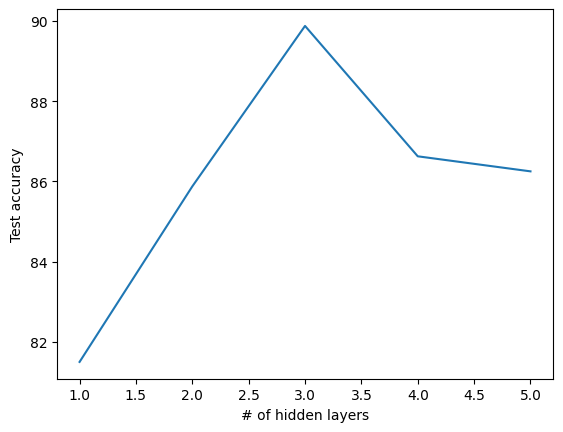

In [7]:
def run_depth_optimizer(max_par_count, max_hidden_layer, device):
  """
  Simulate Depth Optimizer

  Args:
    max_par_count: int
      Maximum number of hidden units in layer of depth optimizer
    max_hidden_layer: int
      Maximum number of hidden layers within depth optimizer
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    hidden_layers: int
      Number of hidden layers in depth optimizer
    test_scores: list
      Log of test scores
  """

  def count_parameters(model):
    """
    Function to count model parameters

    Args:
      model: instance of Net class
        MLP instance

    Returns:
      par_count: int
        Number of parameters in network
    """
    par_count = 0
    for p in model.parameters():
      if p.requires_grad:
        par_count += p.numel()
    return par_count

  # Number of hidden layers to try
  hidden_layers = range(1, max_hidden_layer+1)

  # Test test score list
  test_scores = []

  for hidden_layer in hidden_layers:
    # Initialize the hidden units in each hidden layer to be 1
    hidden_units = np.ones(hidden_layer, dtype=int)

    # Define the the with hidden units equal to 1
    wide_net = Net('ReLU()', X_train.shape[1], hidden_units, K).to(device)
    par_count = count_parameters(wide_net)

    # Increment hidden_units and repeat until the par_count reaches the desired count
    while par_count < max_par_count:
      hidden_units += 1
      wide_net = Net('ReLU()', X_train.shape[1], hidden_units, K).to(device)
      par_count = count_parameters(wide_net)

    # Train it
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(wide_net.parameters(), lr=1e-3)
    _, test_acc = train_test_classification(wide_net, criterion, optimizer,
                                            train_loader, test_loader,
                                            num_epochs=100, device=device)
    test_scores += [test_acc]

  return hidden_layers, test_scores



set_seed(seed=SEED)
max_par_count = 100
max_hidden_layer = 5
## Uncomment below to test your function
hidden_layers, test_scores = run_depth_optimizer(max_par_count, max_hidden_layer, DEVICE)
plt.xlabel('# of hidden layers')
plt.ylabel('Test accuracy')
plt.plot(hidden_layers, test_scores)
plt.show()

In [10]:
def run_poly_classification(poly_degree, device='cpu', seed=0):
  """
  Helper function to run the above defined polynomial classifier

  Args:
    poly_degree: int
      Degree of the polynomial
    device: string
      CUDA/GPU if available, CPU otherwise
    seed: int
      A non-negative integer that defines the random state. Default is 0.

  Returns:
    num_features: int
      Number of features
  """

  def make_poly_features(poly_degree, X):
    """
    Function to define the number of polynomial features except the bias term

    Args:
      poly_degree: int
        Degree of the polynomial
      X: torch.tensor
        Input data

    Returns:
      num_features: int
        Number of features
      poly_X: torch.tensor
        Polynomial term
    """
    num_features = (poly_degree + 1)*(poly_degree + 2) // 2 - 1
    poly_X = torch.zeros((X.shape[0], num_features))
    count = 0
    for i in range(poly_degree+1):
      for j in range(poly_degree+1):
         # No need to add zero degree since model has biases
        if j + i > 0:
          if j + i <= poly_degree:
            # Define the polynomial term
            poly_X[:, count] = X[:, 0]**i * X [:, 1]**j
            count += 1
    return poly_X, num_features

  poly_X_test, num_features = make_poly_features(poly_degree, X_test)
  poly_X_train, _ = make_poly_features(poly_degree, X_train)

  batch_size = 128

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)
  poly_test_data = TensorDataset(poly_X_test, y_test)
  poly_test_loader = DataLoader(poly_test_data,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=1,
                                worker_init_fn=seed_worker,
                                generator=g_seed)

  poly_train_data = TensorDataset(poly_X_train, y_train)
  poly_train_loader = DataLoader(poly_train_data,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=1,
                                 worker_init_fn=seed_worker,
                                 generator=g_seed)

  # Define a linear model using MLP class
  poly_net = Net('ReLU()', num_features, [], K).to(device)

  # Train it!
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(poly_net.parameters(), lr=1e-3)
  _, _ = train_test_classification(poly_net, criterion, optimizer,
                                   poly_train_loader, poly_test_loader,
                                   num_epochs=100, device=DEVICE)
  # Test it
  X_all = sample_grid().to(device)
  poly_X_all, _ = make_poly_features(poly_degree, X_all)
  y_pred = poly_net(poly_X_all.to(device))

  # Plot it
  plot_decision_map(X_all.cpu(), y_pred.cpu(), X_test.cpu(), y_test.cpu())
  plt.show()

  return num_features

max_poly_degree = 50
num_features = run_poly_classification(max_poly_degree, DEVICE, SEED)
print(f'Number of features: {num_features}')

  0%|          | 0/100 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'seed_worker' on <module '__main__' (built-in)>


RuntimeError: DataLoader worker (pid(s) 5562) exited unexpectedly

## Coding Exercise 2

Let’s build our first real-world dataset loader with Data Preprocessing and Augmentation! And we will use the Torchvision transforms to do it. We’d like to have a simple data augmentation with the following steps:

- Random rotation with 10 degrees (.RandomRotation)
- Random horizontal flipping (.RandomHorizontalFlip) and we’d like a preprocessing that:
- makes Pytorch tensors in the range [0,1] (.ToTensor)
- normalizes the input in the range [−1,1] (.Normalize)

Random seed 2021 has been set.


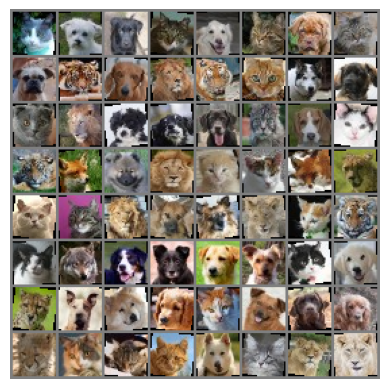

In [12]:
def get_data_loaders(batch_size, seed):
  """
  Helper function to get data loaders

  Args:
    batch_size: int
      Batch size
    seed: int
      A non-negative integer that defines the random state.

  Returns:
    img_train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    img_test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
  """


  # Define the transform done only during training
  augmentation_transforms = [transforms.RandomRotation(10), transforms.RandomHorizontalFlip()]


  # Define the transform done in training and testing (after augmentation)
  mean = (0.5, 0.5, 0.5) # defined sequence of means per channel
  std = (0.5, 0.5, 0.5) # defined sequence of std deviations per channel
  # Note that the transform should normalize each channel: output[channel] = (input[channel] - mean[channel]) / std[channel]
  preprocessing_transforms = [transforms.ToTensor(), transforms.Normalize(mean, std)]

  # Compose them together
  train_transform = transforms.Compose(augmentation_transforms + preprocessing_transforms)
  test_transform = transforms.Compose(preprocessing_transforms)

  # Using pathlib to be compatible with all OS's
  data_path = pathlib.Path('.')/'afhq'

  # Define the dataset objects (they can load one by one)
  img_train_dataset = ImageFolder(data_path/'train', transform=train_transform)
  img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)
  # Define the dataloader objects (they can load batch by batch)
  img_train_loader = DataLoader(img_train_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                worker_init_fn=seed_worker,
                                generator=g_seed)
  # num_workers can be set to higher if running on Colab Pro TPUs to speed up,
  # with more than one worker, it will do multithreading to queue batches
  img_test_loader = DataLoader(img_test_dataset,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers=1,
                               worker_init_fn=seed_worker,
                               generator=g_seed)

  return img_train_loader, img_test_loader


batch_size = 64
set_seed(seed=SEED)
## Uncomment below to test your function
img_train_loader, img_test_loader = get_data_loaders(batch_size, SEED)
# get some random training images
dataiter = iter(img_train_loader)
images, labels = next(dataiter)
# show images
imshow(make_grid(images, nrow=8))

In [13]:
# Train it
set_seed(seed=SEED)
net = Net('ReLU()', 3*32*32, [64, 64, 64], 3).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
_, _ = train_test_classification(net, criterion, optimizer,
                                 img_train_loader, img_test_loader,
                                 num_epochs=30, device=DEVICE)

# Visualize the feature map
fc1_weights = net.mlp[0].weight.view(64, 3, 32, 32).detach().cpu()
fc1_weights /= torch.max(torch.abs(fc1_weights))
imshow(make_grid(fc1_weights, nrow=8))

Random seed 2021 has been set.


  0%|          | 0/30 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/Cellar/python@3.11/3.11.6/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'seed_worker' on <module '__main__' (built-in)>


RuntimeError: DataLoader worker (pid(s) 5929) exited unexpectedly